<a href="https://colab.research.google.com/github/uiinlee/slt/blob/master/Colab_%EC%8B%9C%EC%9E%91%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import gzip
import pickle

file_path = '/content/drive/MyDrive/phoenix14t.pami0.dev'

# 첫 몇 바이트만 로드해서 헤더 구조 확인
with gzip.open(file_path, 'rb') as f:
    try:
        data = pickle.load(f)
        for i, sample in enumerate(data[:3]):
            print(f"\nSample {i}: {list(sample.keys())}")
    except Exception as e:
        print("Error loading sample:", e)



Sample 0: ['name', 'signer', 'gloss', 'text', 'sign']

Sample 1: ['name', 'signer', 'gloss', 'text', 'sign']

Sample 2: ['name', 'signer', 'gloss', 'text', 'sign']


In [35]:
import torch

sign_list = []

for i, entry in enumerate(data):
    sign = entry.get("sign", None)
    if isinstance(sign, torch.Tensor) and sign.numel() > 0:
        sign_list.append(sign)


print(len(sign_list))


519


In [14]:
#########################################
# 단일 샘플 대상
#########################################
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# --- GCN 관련 모듈 ---

class GraphConvolution(nn.Module):
    """
    Graph Convolution Layer:
    - 입력: x ∈ [N, in_features] (여기서 N은 프레임 수)
           adj ∈ [N, N] (정규화된 인접 행렬)
    - 출력: [N, out_features]
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.bias is not None:
            output = output + self.bias
        return output

class GCNFeature(nn.Module):
    """
    두 계층의 GCN을 통해 입력 프레임별 특징을 추출합니다.
    - 입력: [N, nfeat]
    - 출력: [N, gcn_out]
    """
    def __init__(self, nfeat, nhid, gcn_out, dropout):
        super(GCNFeature, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, gcn_out)
        self.dropout = dropout

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return x

# --- ResNet 1D 관련 모듈 ---

class BasicBlock1D(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet1D(nn.Module):
    def __init__(self, in_channels, num_blocks, out_channels):
        """
        in_channels: 입력 채널 (GCN의 출력, 즉 gcn_out)
        num_blocks: 사용할 ResNet 블록 수
        out_channels: 최종 출력 채널 (원하는 n 차원)
        """
        super(ResNet1D, self).__init__()
        layers = []
        downsample = None
        if in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm1d(out_channels)
            )
        layers.append(BasicBlock1D(in_channels, out_channels, stride=1, downsample=downsample))
        for i in range(1, num_blocks):
            layers.append(BasicBlock1D(out_channels, out_channels))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# --- GCN과 ResNet을 결합한 모델 ---
# 여기서 모델은 최종적으로 2048차원 feature를 생성하며,
# 추가된 projection layer를 통해 2048차원 feature를 1024로 재구성하여 loss 계산에 사용합니다.

class GCN_ResNet(nn.Module):
    def __init__(self, nfeat, nhid, gcn_out, dropout, out_feature_dim, num_resnet_blocks=2):
        """
        nfeat: 각 프레임의 입력 특징 차원 (1024)
        nhid: GCN의 은닉 차원
        gcn_out: GCN의 출력 차원 (중간 특징)
        dropout: GCN dropout 비율
        out_feature_dim: 최종 출력 특징 차원 (여기서는 2048)
        num_resnet_blocks: 사용할 ResNet 블록 수
        """
        super(GCN_ResNet, self).__init__()
        self.gcn = GCNFeature(nfeat, nhid, gcn_out, dropout)
        self.resnet = ResNet1D(in_channels=gcn_out, num_blocks=num_resnet_blocks, out_channels=out_feature_dim)
        # Projection layer: 2048 -> 1024, 재구성을 위한 출력
        self.proj = nn.Linear(out_feature_dim, nfeat)

    def forward(self, x, adj):
        features = self.gcn(x, adj)   # [N, gcn_out]
        features = features.transpose(0, 1).unsqueeze(0)  # [1, gcn_out, N]
        resnet_out = self.resnet(features)                # [1, out_feature_dim (2048), N]
        # Expanded feature representation: [N, 2048]
        features_expanded = resnet_out.squeeze(0).transpose(0, 1)
        # Reconstruction: project expanded features to original dimension [N, 1024]
        reconstruction = self.proj(features_expanded)
        return features_expanded, reconstruction

# --- 학습 코드 예제 ---

# 원본 sign 데이터 (NumPy 배열), shape: [150, 1024]
sign_data_np = sign_list[1]
print("원본 sign 데이터 shape:", sign_data_np.shape)

# 학습 데이터를 텐서로 변환
sign_data = torch.tensor(sign_data_np, dtype=torch.float32)  # [150, 1024]

N = sign_data.shape[0]      # 150
nfeat = sign_data.shape[1]  # 1024

# 하이퍼파라미터 설정
nhid = 512
gcn_out = 256
dropout = 0.5
out_feature_dim = 2048  # 최종 출력 feature는 2048차원으로 생성
num_resnet_blocks = 2

adj = torch.eye(N)

# 모델 생성
model = GCN_ResNet(nfeat, nhid, gcn_out, dropout, out_feature_dim, num_resnet_blocks)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
min_loss_threshold = 0.001

loss_history = []

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    features_expanded, reconstruction = model(sign_data, adj)  # features_expanded: [150, 2048], reconstruction: [150, 1024]
    loss = criterion(reconstruction, sign_data)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

    if loss.item() < min_loss_threshold:
        print(f"Early stopping at epoch {epoch+1}, Loss: {loss.item():.6f}")
        break

model.eval()
with torch.no_grad():
    features_expanded, reconstruction = model(sign_data, adj)
    print("최종 확장된 출력 shape:", features_expanded.shape)  # 예상: [150, 2048]
    print("재구성된 출력 shape:", reconstruction.shape)       # 예상: [150, 1024]
    print(reconstruction)

plt.figure(figsize=(8, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


원본 sign 데이터 shape: torch.Size([150, 1024])


<ipython-input-14-e0e7ee2d529e>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sign_data = torch.tensor(sign_data_np, dtype=torch.float32)  # [150, 1024]


Epoch [10/1000], Loss: 0.760225


KeyboardInterrupt: 

In [19]:
#########################################
# 다중 샘플 대상
#########################################
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import math
import gzip
import pickle

# --- 1. Load sign_list from the file ---
file_path = '/content/drive/MyDrive/phoenix14t.pami0.test'
with gzip.open(file_path, 'rb') as f:
    data = pickle.load(f)

sign_list = []
for entry in data:
    sign = entry.get("sign", None)
    if isinstance(sign, torch.Tensor) and sign.numel() > 0:
        sign_list.append(sign)

# print(sign_list)
# --- 2. Custom Dataset ---
"""
PyTorch의 Dataset을 상속받아 sign_list를 사용해 길이와 개별 항목 반환 기능을 제공.

"""
class SignDataset(Dataset):
    def __init__(self, sign_list):
        self.samples = [s for s in sign_list if isinstance(s, torch.Tensor) and s.numel() > 0]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # [T, 512]

# # 1. Dataset 객체 생성
# dataset = SignDataset(sign_list)

# # 2. 전체 길이 확인
# print(f"총 샘플 수: {len(dataset)}")

# # 3. 몇 개의 샘플 shape 확인
# for i in range(len(dataset)):  # 앞의 3개만 예시
#     sample = dataset[i]
#     print(f"샘플 {i} → 타입: {type(sample)}, shape: {sample.shape}")

# --- 3. Collate Function for Padding ---
"""
배치의 시퀀스 길이(T)가 다르므로, pad_sequence로 batch_first=True 형태로 패딩.
mask도 생성하여 나중에 사용할 수 있도록 함께 반환 (이후 활용 가능성 있음).
"""
def pad_collate_fn(batch):
    lengths = [s.shape[0] for s in batch]
    padded = rnn_utils.pad_sequence(batch, batch_first=True)  # [B, T_max, 512]
    mask = torch.zeros(padded.shape[:2], dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :l] = True
    return padded, mask, lengths

# --- 4. GCN Layer ---
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            output = output + self.bias
        return output

# --- 5. GCN Feature Extractor ---
class GCNFeature(nn.Module):
    def __init__(self, nfeat, nhid, gcn_out, dropout):
        super(GCNFeature, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, gcn_out)
        self.dropout = dropout

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return x

# --- 6. Simple Model for Batched Training ---
class GCNModel(nn.Module):
    def __init__(self, input_dim=1024, nhid=512, gcn_out=256, dropout=0.5):
        super(GCNModel, self).__init__()
        self.gcn = GCNFeature(input_dim, nhid, gcn_out, dropout)
        self.proj = nn.Linear(gcn_out, input_dim)

    def forward(self, x, mask):
        B, T, F = x.shape
        adj = torch.eye(T, device=x.device).unsqueeze(0).expand(B, T, T)
        x_out = torch.stack([
            self.gcn(x[i], adj[i]) for i in range(B)
        ])
        recon = self.proj(x_out)
        return x_out, recon

# --- 7. Training Loop (one epoch) ---
dataset = SignDataset(sign_list)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pad_collate_fn, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCNModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

batch_data, batch_mask, batch_lengths = next(iter(dataloader))
batch_data = batch_data.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_data, batch_mask, batch_lengths in dataloader:
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()
        _, recon = model(batch_data, batch_mask)
        loss = criterion(recon, batch_data)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

Epoch 1/1000, Loss: 215.919576
Epoch 2/1000, Loss: 157.432156
Epoch 3/1000, Loss: 148.058938
Epoch 4/1000, Loss: 141.310526
Epoch 5/1000, Loss: 138.840350
Epoch 6/1000, Loss: 136.493077
Epoch 7/1000, Loss: 135.316652
Epoch 8/1000, Loss: 135.923134
Epoch 9/1000, Loss: 134.870222
Epoch 10/1000, Loss: 134.132376
Epoch 11/1000, Loss: 131.311361
Epoch 12/1000, Loss: 133.620567
Epoch 13/1000, Loss: 129.488819
Epoch 14/1000, Loss: 131.090469
Epoch 15/1000, Loss: 130.223111
Epoch 16/1000, Loss: 130.600120
Epoch 17/1000, Loss: 128.847538
Epoch 18/1000, Loss: 130.118520
Epoch 19/1000, Loss: 130.357418
Epoch 20/1000, Loss: 129.322887
Epoch 21/1000, Loss: 129.067321
Epoch 22/1000, Loss: 127.733590
Epoch 23/1000, Loss: 128.727101
Epoch 24/1000, Loss: 127.802029
Epoch 25/1000, Loss: 127.015779
Epoch 26/1000, Loss: 129.602794
Epoch 27/1000, Loss: 128.410415
Epoch 28/1000, Loss: 126.089887
Epoch 29/1000, Loss: 127.442349
Epoch 30/1000, Loss: 127.667672
Epoch 31/1000, Loss: 126.654041
Epoch 32/1000, Lo

KeyboardInterrupt: 

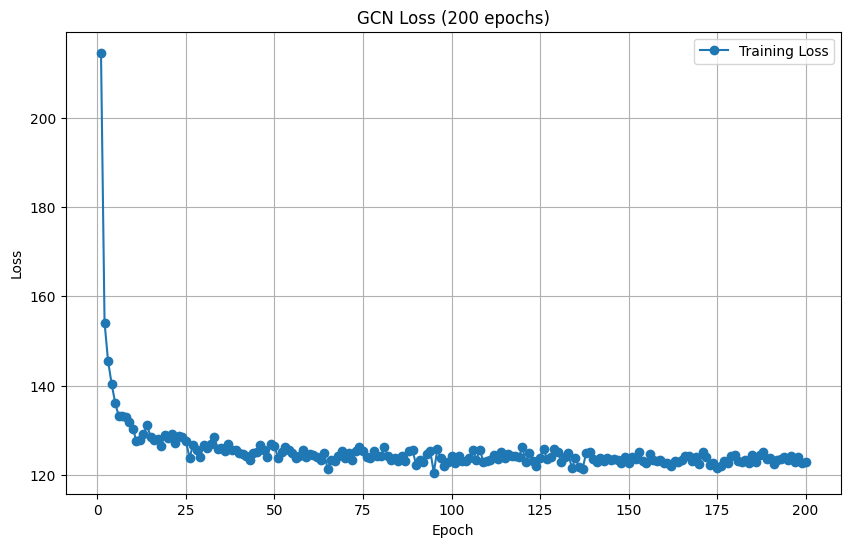

In [23]:
import matplotlib.pyplot as plt

# 제공된 로그 값을 리스트로 정의 (200 에포크 손실 값)
loss_history = [
    214.600402, 154.125191, 145.454544, 140.401477, 136.118971, 133.181216,
    133.213680, 132.870045, 131.802270, 130.348779, 127.586870, 127.811640,
    129.096848, 131.193661, 128.523497, 127.834811, 128.093504, 126.514972,
    128.844567, 128.247325, 129.048687, 127.202059, 128.606183, 128.506560,
    127.597315, 123.708102, 126.763789, 125.575813, 123.932999, 126.600180,
    126.009430, 126.973655, 128.437748, 125.809833, 126.090357, 125.236862,
    126.819237, 125.651584, 125.643468, 124.824800, 124.724527, 124.258359,
    123.377870, 124.914062, 125.005183, 126.662057, 125.588517, 124.067716,
    126.939941, 126.558290, 123.695944, 125.050098, 126.246373, 125.553043,
    124.837218, 123.699648, 124.229172, 125.618615, 123.908036, 124.666303,
    124.455802, 123.966907, 123.335651, 124.872462, 121.350792, 123.293085,
    122.980132, 124.129895, 125.418421, 123.817230, 124.794061, 123.299527,
    125.383913, 126.232317, 125.280618, 123.980228, 123.792120, 125.338920,
    124.277188, 124.293250, 126.206684, 124.218180, 123.210597, 123.675630,
    123.049424, 124.132774, 123.146642, 125.240750, 125.472941, 122.270346,
    123.363264, 122.939036, 124.576708, 125.317694, 120.458221, 125.746457,
    123.743127, 121.854772, 122.889510, 124.107247, 122.591893, 124.165219,
    122.994462, 123.125995, 123.707213, 125.582425, 123.353099, 125.609383,
    122.910781, 123.018840, 123.243929, 124.348138, 123.625896, 125.078741,
    123.747787, 124.640424, 124.155028, 124.155568, 123.894645, 126.127996,
    122.805765, 124.912450, 123.018279, 121.992135, 123.827573, 125.781668,
    123.464530, 123.932930, 125.784733, 125.142435, 122.906122, 123.873588,
    124.890761, 121.432986, 123.838850, 121.692221, 121.248633, 124.788847,
    125.075368, 123.569196, 122.887369, 123.650871, 123.122360, 123.694983,
    123.285698, 123.640164, 123.330688, 122.694896, 123.931326, 122.744519,
    124.069694, 123.431955, 125.126593, 123.188532, 122.560723, 124.746637,
    123.340476, 123.011037, 123.351523, 122.569106, 122.710716, 122.023313,
    123.142566, 122.924059, 123.257100, 124.214749, 124.244751, 123.038981,
    123.878845, 122.522967, 125.036398, 124.021388, 122.083068, 122.697277,
    121.491455, 122.054593, 123.038156, 122.736904, 124.314277, 124.482540,
    123.114648, 122.755656, 123.254117, 122.625343, 124.352926, 122.764369,
    124.438389, 125.088252, 123.548831, 123.667613, 122.438581, 123.213000,
    123.635769, 123.996924, 123.243929, 124.176930, 122.833583, 124.002377,
    122.691249, 122.764980
]

# 에포크 번호 생성 (1부터 200까지)
epochs = list(range(1, len(loss_history) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history, marker='o', linestyle='-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Loss (200 epochs)')
plt.legend()
plt.grid(True)
plt.show()


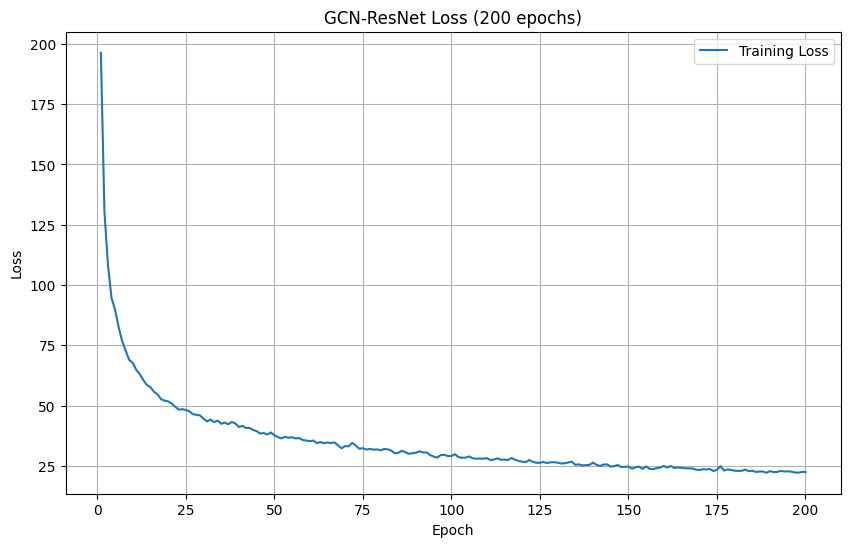

In [97]:
# GCN epochs 200 result
import matplotlib.pyplot as plt

# 제공된 로그 값을 리스트로 정의 (여기서는 예시로 일부 값만 포함)
loss_history = [
    196.307250, 130.618691, 108.299891, 94.668099, 89.862828, 82.675771,
    76.826410, 72.808794, 68.958767, 67.781170, 64.871323, 63.042787,
    60.628961, 58.598392, 57.685779, 55.804800, 54.708357, 52.694692,
    52.093114, 51.795569, 50.906049, 49.563425, 48.358797, 48.560759,
    48.209728, 47.703378, 46.461803, 46.218674, 45.997223, 44.603461,
    43.506828, 44.237330, 43.175441, 43.829243, 42.490425, 43.024432,
    42.306291, 43.266471, 42.637200, 41.162311, 41.619054, 40.788011,
    40.796647, 39.945599, 39.453196, 38.453317, 38.672988, 38.063263,
    38.911801, 37.760905, 36.982200, 36.430891, 37.104023, 36.712692,
    36.944964, 36.421695, 36.583375, 35.802991, 35.559701, 35.300002,
    35.574252, 34.488688, 34.941054, 34.463305, 34.734239, 34.520236,
    34.794503, 33.494443, 32.356205, 33.256568, 33.152736, 34.591926,
    33.478875, 32.158319, 32.404024, 31.823111, 32.106828, 31.767929,
    31.901639, 31.490858, 32.050381, 31.921409, 31.397198, 30.270994,
    30.466768, 31.289485, 30.707383, 30.033341, 30.324984, 30.535481,
    31.095329, 30.642800, 30.610641, 29.556498, 28.938911, 28.484641,
    29.534681, 29.650297, 29.137141, 29.121678, 29.917630, 28.711338,
    28.420124, 28.462292, 28.964275, 28.224586, 28.019151, 28.097599,
    28.005034, 28.259203, 27.490782, 27.674178, 28.161649, 27.584769,
    27.666485, 27.494700, 28.340266, 27.574390, 27.095555, 26.802376,
    26.611741, 27.490949, 26.731122, 26.355461, 26.337945, 26.661243,
    26.211223, 26.533763, 26.557974, 26.377386, 26.050750, 26.131258,
    26.438848, 26.810490, 25.525624, 25.672405, 25.246551, 25.360259,
    25.470703, 26.417542, 25.509244, 25.019948, 25.615623, 25.666595,
    24.755684, 24.961621, 25.392451, 24.559097, 24.661953, 24.760020,
    23.903812, 24.468962, 24.728763, 23.846142, 24.819098, 23.819996,
    23.705777, 24.103112, 24.362959, 25.034673, 24.367882, 25.011959,
    24.161875, 24.441926, 24.212755, 24.077467, 23.985523, 24.056453,
    23.520604, 23.350232, 23.686016, 23.570655, 23.749404, 22.919276,
    23.398003, 24.971096, 23.104455, 23.585809, 23.396181, 23.058707,
    22.975395, 23.007055, 23.494648, 22.853186, 23.038094, 22.549949,
    22.722563, 22.699758, 22.218819, 22.900465, 22.469616, 22.546519,
    22.975192, 22.746106, 22.811247, 22.660023, 22.306444, 22.225509,
    22.569168, 22.492214
]

# 에포크 번호 생성 (1부터 200까지)
epochs = list(range(1, len(loss_history) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history, linestyle='-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN-ResNet Loss (200 epochs)')
plt.legend()
plt.grid(True)
plt.show()


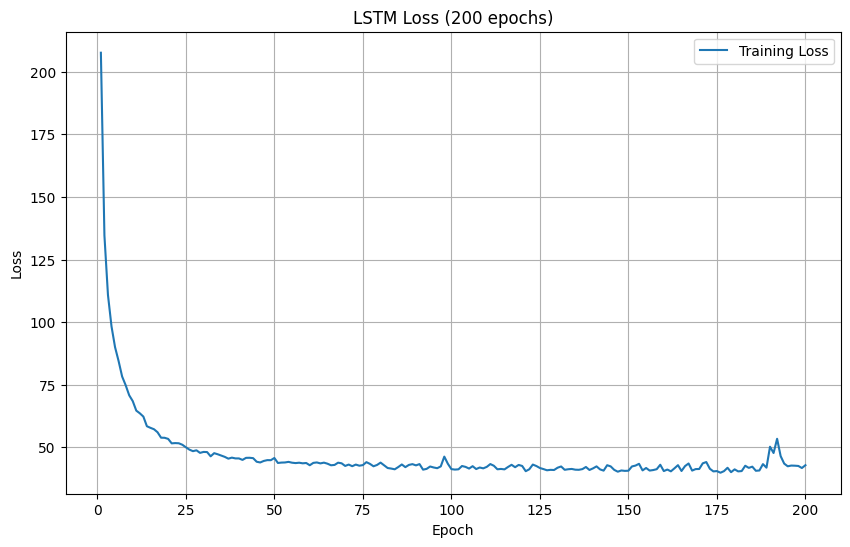

In [98]:
import matplotlib.pyplot as plt

loss_history =  [
    207.567158, 134.627976, 110.839341, 98.311970, 90.005243, 84.474175, 78.283742, 74.801161, 70.782967, 68.453507,
    64.656924, 63.585297, 62.279444, 58.419913, 57.786343, 57.219302, 56.027638, 53.849015, 53.811799, 53.369955,
    51.589021, 51.690923, 51.618726, 51.036706, 50.029387, 49.084655, 48.468623, 48.809397, 47.783766, 48.160573,
    48.108984, 46.411861, 47.667444, 47.229971, 46.692253, 46.189255, 45.477072, 45.882905, 45.577897, 45.567380,
    44.977831, 45.797219, 45.827851, 45.676900, 44.247840, 43.955685, 44.559767, 44.888729, 44.868803, 45.739152,
    43.757696, 43.907932, 43.958435, 44.191654, 43.861380, 43.707780, 43.855329, 43.615814, 43.741415, 42.847215,
    43.789122, 43.962649, 43.587096, 43.883959, 43.469382, 42.834335, 42.972059, 43.869715, 43.613832, 42.571777,
    43.117708, 42.463719, 43.114446, 42.665813, 42.904211, 44.081674, 43.391136, 42.436870, 42.954168, 43.897965,
    42.827974, 41.739265, 41.522653, 41.223734, 42.131860, 43.159096, 42.090134, 42.980508, 43.282372, 42.798304,
    43.304210, 41.083551, 41.397049, 42.343289, 41.951163, 41.670197, 42.382213, 46.291337, 43.450705, 41.299851,
    41.115453, 41.220070, 42.539511, 42.189321, 41.519854, 42.473143, 41.330357, 41.939819, 41.606159, 42.199642,
    43.317140, 42.637350, 41.232807, 41.372927, 41.197920, 42.160443, 43.023083, 42.062516, 42.975630, 42.559789,
    40.473304, 41.232758, 43.115570, 42.537552, 41.741959, 41.316854, 40.838443, 41.006819, 40.947419, 41.862243,
    42.356594, 41.027771, 41.247086, 41.367184, 41.074153, 41.024822, 41.300634, 42.152971, 40.960187, 41.595209,
    42.394395, 41.187026, 40.699986, 42.858212, 42.382794, 40.997100, 40.274336, 40.757409, 40.599808, 40.657409,
    42.362516, 42.711158, 43.416769, 40.791064, 41.747712, 40.722014, 40.924107, 41.275253, 43.043228, 40.525687,
    41.127100, 40.414246, 41.611158, 42.880314, 40.550416, 42.507355, 43.555041, 40.711486, 41.312235, 41.349838,
    43.612280, 44.121551, 41.457079, 40.392433, 40.513586, 39.860558, 40.495865, 41.833988, 40.083270, 41.202103,
    40.396045, 40.522673, 42.642539, 41.800118, 42.278731, 40.638696, 40.756080, 43.300581, 41.880681, 50.243865,
    47.728074, 53.412427, 46.504850, 43.504710, 42.429608, 42.717230, 42.667470, 42.566595, 41.737196, 42.859287
]


epochs = list(range(1, 201))  # 에포크 1부터 200까지

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history, linestyle='-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Loss (200 epochs)')
plt.legend()
plt.grid(True)
plt.show()


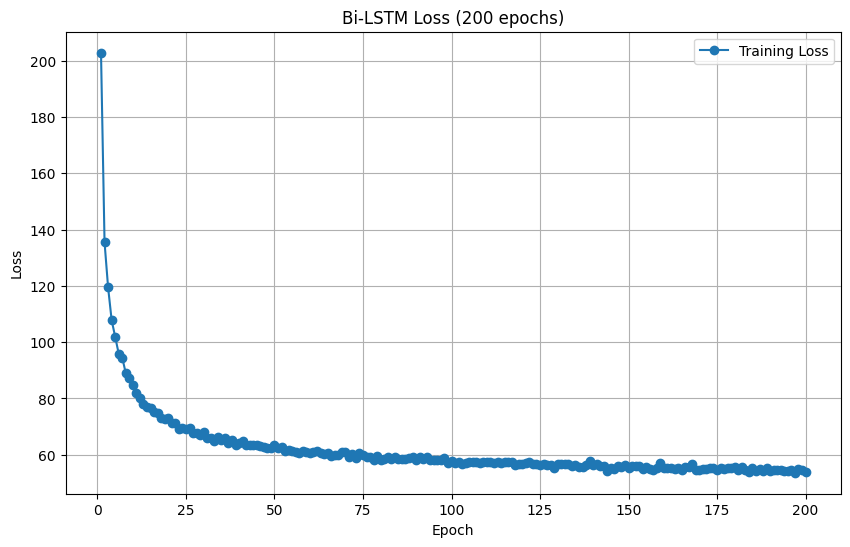

In [87]:
import matplotlib.pyplot as plt

loss_history = [
    202.816586, 135.462417, 119.466256, 107.854664, 101.817599, 95.896988, 94.472941, 88.924011, 87.412387, 84.755544,
    81.841378, 80.297045, 78.099952, 76.995637, 76.664695, 75.072072, 74.693314, 72.975794, 72.800106, 73.165763,
    71.379155, 71.378058, 69.136368, 69.647185, 69.162640, 69.625516, 67.787625, 67.825703, 66.923472, 68.221192,
    65.798161, 66.000780, 64.745710, 66.286554, 65.088968, 65.921339, 64.249153, 65.294860, 63.589244, 64.078322,
    64.702286, 63.408180, 63.529469, 63.270064, 63.482949, 63.019161, 62.632602, 62.529804, 62.496606, 63.540278,
    62.507186, 62.818223, 61.294889, 61.639178, 61.310797, 61.080768, 60.646423, 61.207015, 60.918920, 60.762430,
    60.987157, 61.367456, 60.647922, 60.353383, 60.638649, 59.637075, 60.033059, 59.920037, 60.877290, 61.001235,
    59.336839, 60.176187, 58.808271, 60.436193, 59.745762, 59.259920, 59.034936, 58.245434, 59.374891, 58.253857,
    58.548053, 59.089764, 58.533623, 59.116728, 58.396056, 58.605299, 58.380637, 58.911716, 59.043917, 58.220881,
    59.175650, 58.362497, 59.148573, 58.117457, 57.985926, 58.246759, 58.081567, 58.813701, 57.020182, 57.680902,
    57.215483, 57.377903, 56.582460, 57.010750, 57.494177, 57.489878, 57.415920, 57.211295, 57.414833, 57.246518,
    57.448977, 57.107724, 57.250594, 56.940858, 57.275492, 57.347284, 57.346531, 56.485765, 56.601929, 56.634387,
    56.943160, 57.431704, 56.845411, 56.836191, 56.173522, 56.762049, 56.483449, 56.461348, 55.147411, 56.733790,
    56.536756, 56.772926, 56.662498, 55.883767, 56.347427, 55.772381, 55.619460, 56.387715, 57.812476, 56.375229,
    56.682585, 56.036121, 55.811512, 54.302372, 55.423225, 55.020447, 56.093050, 55.628363, 56.391563, 55.335659,
    55.882309, 55.839915, 55.879326, 55.045278, 55.789255, 54.745044, 54.712774, 55.137994, 56.984803, 55.324585,
    55.203061, 55.298049, 54.924236, 55.349013, 54.504324, 55.679517, 55.583237, 56.546715, 54.516447, 54.630433,
    54.853505, 55.041028, 55.403065, 55.216295, 54.575423, 55.386734, 54.749854, 55.224185, 55.394037, 55.506221,
    54.617141, 55.772047, 54.550626, 53.886869, 55.244055, 54.367812, 54.808838, 54.308618, 55.318636, 54.212549,
    54.424002, 54.465699, 54.415539, 54.210195, 54.083132, 54.446730, 53.591877, 54.798934, 54.534105, 53.964508
]

epochs = list(range(1, 201))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history, marker='o', linestyle='-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bi-LSTM Loss (200 epochs)')
plt.legend()
plt.grid(True)
plt.show()


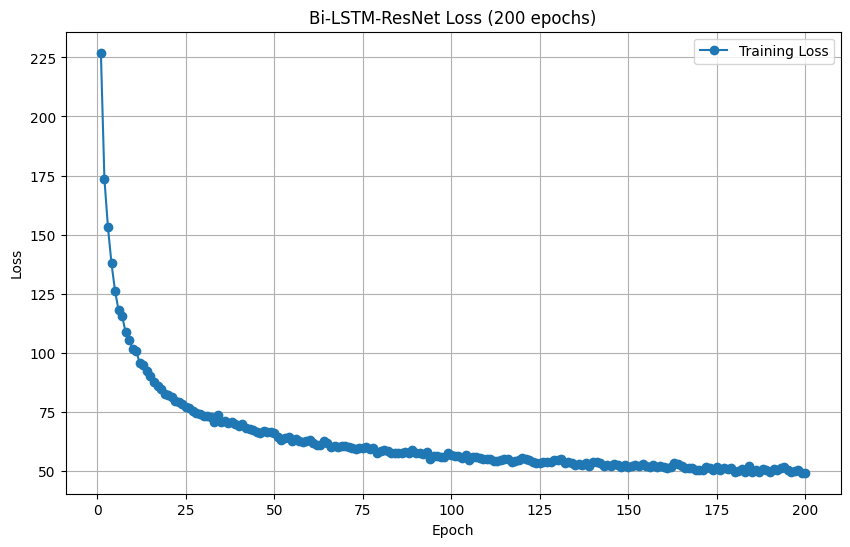

In [90]:
import matplotlib.pyplot as plt

loss_history = [
    226.995033, 173.546701, 152.998812, 137.767856, 126.165267, 117.949873, 115.490547, 108.572101, 105.479816, 101.437698,
    100.515252, 95.550768, 94.901683, 92.098002, 89.943129, 87.648590, 85.758415, 84.651494, 82.673905, 82.178759,
    81.436631, 79.340226, 78.977928, 78.323762, 76.959066, 76.420429, 75.443943, 74.649041, 74.227407, 73.113545,
    73.272577, 72.929059, 70.461241, 73.582180, 70.854393, 71.257827, 70.038452, 70.444521, 69.630117, 69.111720,
    69.639431, 67.935383, 67.676853, 67.228382, 66.292798, 65.832540, 67.001860, 66.566287, 66.470665, 65.816037,
    64.341984, 63.231561, 63.738460, 64.102773, 62.739109, 63.246365, 62.628788, 62.264706, 62.598599, 63.137011,
    61.556559, 60.859384, 60.875028, 62.406122, 61.593596, 59.851771, 60.649568, 59.993549, 60.304655, 60.550000,
    59.996131, 59.812118, 59.251644, 59.440409, 59.430960, 59.944988, 59.280617, 59.540973, 57.654823, 58.206129,
    58.744283, 58.290730, 57.549376, 57.421128, 57.643765, 57.413223, 57.846658, 57.505436, 58.818506, 57.453368,
    57.328413, 56.940861, 57.789553, 54.966082, 56.316160, 56.110853, 55.814701, 55.688734, 57.364597, 56.493378,
    56.237831, 56.205093, 55.237583, 56.682838, 54.523483, 56.011877, 55.929489, 55.518001, 55.042461, 55.064095,
    54.885302, 54.112676, 54.237729, 54.564102, 55.077370, 55.062370, 53.892385, 54.214947, 54.614816, 55.511374,
    55.058201, 54.660040, 53.848155, 53.222535, 53.325343, 53.791777, 53.667465, 53.787121, 54.479746, 54.461485,
    54.829579, 53.329505, 53.596872, 53.154014, 52.648591, 52.834487, 52.282617, 53.484481, 52.122088, 53.615794,
    53.517893, 53.094886, 52.218211, 52.296502, 51.964738, 52.920535, 52.572915, 51.433083, 52.604278, 51.686016,
    51.940135, 52.566351, 52.117689, 52.693188, 52.091665, 51.748972, 52.441582, 51.610237, 52.122798, 51.727836,
    51.372895, 51.471985, 53.088250, 52.833618, 52.025084, 51.210262, 51.195369, 51.354309, 50.358797, 50.433811,
    50.133655, 51.398892, 51.343676, 50.304891, 51.778477, 50.354727, 51.072935, 50.670811, 51.312686, 49.602147,
    50.065495, 50.813529, 49.469904, 51.891292, 49.411782, 50.269675, 49.319886, 50.716448, 50.485832, 49.430931,
    50.563133, 50.226759, 50.990238, 51.600768, 50.269646, 49.579364, 50.019024, 50.395677, 49.171635, 49.183934
]
epochs = list(range(1, 201))

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history, marker='o', linestyle='-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Bi-LSTM-ResNet Loss (200 epochs)')
plt.legend()
plt.grid(True)
plt.show()


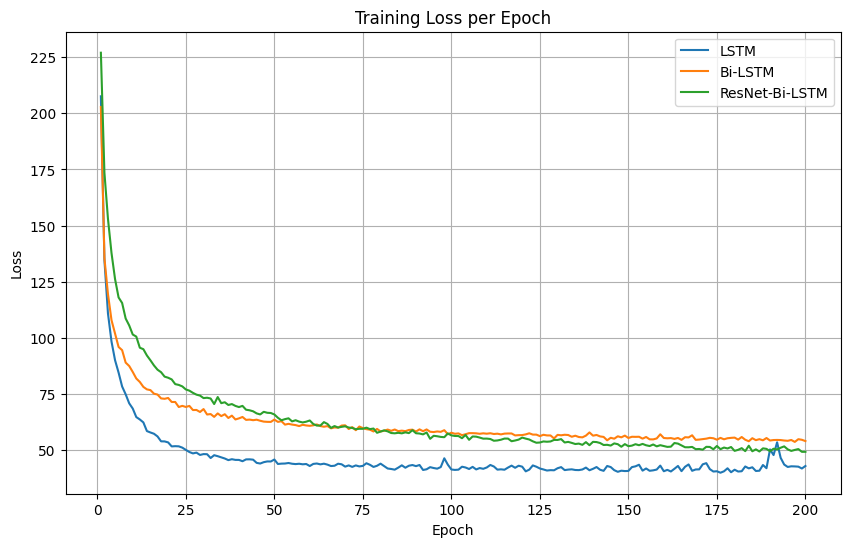

In [93]:
import matplotlib.pyplot as plt

epochs = list(range(1, 201))

# LSTM Loss 리스트
lstm_losses = [
    207.567158, 134.627976, 110.839341, 98.311970, 90.005243, 84.474175, 78.283742, 74.801161, 70.782967, 68.453507,
    64.656924, 63.585297, 62.279444, 58.419913, 57.786343, 57.219302, 56.027638, 53.849015, 53.811799, 53.369955,
    51.589021, 51.690923, 51.618726, 51.036706, 50.029387, 49.084655, 48.468623, 48.809397, 47.783766, 48.160573,
    48.108984, 46.411861, 47.667444, 47.229971, 46.692253, 46.189255, 45.477072, 45.882905, 45.577897, 45.567380,
    44.977831, 45.797219, 45.827851, 45.676900, 44.247840, 43.955685, 44.559767, 44.888729, 44.868803, 45.739152,
    43.757696, 43.907932, 43.958435, 44.191654, 43.861380, 43.707780, 43.855329, 43.615814, 43.741415, 42.847215,
    43.789122, 43.962649, 43.587096, 43.883959, 43.469382, 42.834335, 42.972059, 43.869715, 43.613832, 42.571777,
    43.117708, 42.463719, 43.114446, 42.665813, 42.904211, 44.081674, 43.391136, 42.436870, 42.954168, 43.897965,
    42.827974, 41.739265, 41.522653, 41.223734, 42.131860, 43.159096, 42.090134, 42.980508, 43.282372, 42.798304,
    43.304210, 41.083551, 41.397049, 42.343289, 41.951163, 41.670197, 42.382213, 46.291337, 43.450705, 41.299851,
    41.115453, 41.220070, 42.539511, 42.189321, 41.519854, 42.473143, 41.330357, 41.939819, 41.606159, 42.199642,
    43.317140, 42.637350, 41.232807, 41.372927, 41.197920, 42.160443, 43.023083, 42.062516, 42.975630, 42.559789,
    40.473304, 41.232758, 43.115570, 42.537552, 41.741959, 41.316854, 40.838443, 41.006819, 40.947419, 41.862243,
    42.356594, 41.027771, 41.247086, 41.367184, 41.074153, 41.024822, 41.300634, 42.152971, 40.960187, 41.595209,
    42.394395, 41.187026, 40.699986, 42.858212, 42.382794, 40.997100, 40.274336, 40.757409, 40.599808, 40.657409,
    42.362516, 42.711158, 43.416769, 40.791064, 41.747712, 40.722014, 40.924107, 41.275253, 43.043228, 40.525687,
    41.127100, 40.414246, 41.611158, 42.880314, 40.550416, 42.507355, 43.555041, 40.711486, 41.312235, 41.349838,
    43.612280, 44.121551, 41.457079, 40.392433, 40.513586, 39.860558, 40.495865, 41.833988, 40.083270, 41.202103,
    40.396045, 40.522673, 42.642539, 41.800118, 42.278731, 40.638696, 40.756080, 43.300581, 41.880681, 50.243865,
    47.728074, 53.412427, 46.504850, 43.504710, 42.429608, 42.717230, 42.667470, 42.566595, 41.737196, 42.859287
]

# Bi-LSTM Loss 리스트
bi_lstm_losses = [
    202.816586, 135.462417, 119.466256, 107.854664, 101.817599, 95.896988, 94.472941, 88.924011, 87.412387, 84.755544,
    81.841378, 80.297045, 78.099952, 76.995637, 76.664695, 75.072072, 74.693314, 72.975794, 72.800106, 73.165763,
    71.379155, 71.378058, 69.136368, 69.647185, 69.162640, 69.625516, 67.787625, 67.825703, 66.923472, 68.221192,
    65.798161, 66.000780, 64.745710, 66.286554, 65.088968, 65.921339, 64.249153, 65.294860, 63.589244, 64.078322,
    64.702286, 63.408180, 63.529469, 63.270064, 63.482949, 63.019161, 62.632602, 62.529804, 62.496606, 63.540278,
    62.507186, 62.818223, 61.294889, 61.639178, 61.310797, 61.080768, 60.646423, 61.207015, 60.918920, 60.762430,
    60.987157, 61.367456, 60.647922, 60.353383, 60.638649, 59.637075, 60.033059, 59.920037, 60.877290, 61.001235,
    59.336839, 60.176187, 58.808271, 60.436193, 59.745762, 59.259920, 59.034936, 58.245434, 59.374891, 58.253857,
    58.548053, 59.089764, 58.533623, 59.116728, 58.396056, 58.605299, 58.380637, 58.911716, 59.043917, 58.220881,
    59.175650, 58.362497, 59.148573, 58.117457, 57.985926, 58.246759, 58.081567, 58.813701, 57.020182, 57.680902,
    57.215483, 57.377903, 56.582460, 57.010750, 57.494177, 57.489878, 57.415920, 57.211295, 57.414833, 57.246518,
    57.448977, 57.107724, 57.250594, 56.940858, 57.275492, 57.347284, 57.346531, 56.485765, 56.601929, 56.634387,
    56.943160, 57.431704, 56.845411, 56.836191, 56.173522, 56.762049, 56.483449, 56.461348, 55.147411, 56.733790,
    56.536756, 56.772926, 56.662498, 55.883767, 56.347427, 55.772381, 55.619460, 56.387715, 57.812476, 56.375229,
    56.682585, 56.036121, 55.811512, 54.302372, 55.423225, 55.020447, 56.093050, 55.628363, 56.391563, 55.335659,
    55.882309, 55.839915, 55.879326, 55.045278, 55.789255, 54.745044, 54.712774, 55.137994, 56.984803, 55.324585,
    55.203061, 55.298049, 54.924236, 55.349013, 54.504324, 55.679517, 55.583237, 56.546715, 54.516447, 54.630433,
    54.853505, 55.041028, 55.403065, 55.216295, 54.575423, 55.386734, 54.749854, 55.224185, 55.394037, 55.506221,
    54.617141, 55.772047, 54.550626, 53.886869, 55.244055, 54.367812, 54.808838, 54.308618, 55.318636, 54.212549,
    54.424002, 54.465699, 54.415539, 54.210195, 54.083132, 54.446730, 53.591877, 54.798934, 54.534105, 53.964508
]

# ResNet-Bi-LSTM Loss 리스트
resnet_bi_lstm_losses = [
    226.995033, 173.546701, 152.998812, 137.767856, 126.165267, 117.949873, 115.490547, 108.572101, 105.479816, 101.437698,
    100.515252, 95.550768, 94.901683, 92.098002, 89.943129, 87.648590, 85.758415, 84.651494, 82.673905, 82.178759,
    81.436631, 79.340226, 78.977928, 78.323762, 76.959066, 76.420429, 75.443943, 74.649041, 74.227407, 73.113545,
    73.272577, 72.929059, 70.461241, 73.582180, 70.854393, 71.257827, 70.038452, 70.444521, 69.630117, 69.111720,
    69.639431, 67.935383, 67.676853, 67.228382, 66.292798, 65.832540, 67.001860, 66.566287, 66.470665, 65.816037,
    64.341984, 63.231561, 63.738460, 64.102773, 62.739109, 63.246365, 62.628788, 62.264706, 62.598599, 63.137011,
    61.556559, 60.859384, 60.875028, 62.406122, 61.593596, 59.851771, 60.649568, 59.993549, 60.304655, 60.550000,
    59.996131, 59.812118, 59.251644, 59.440409, 59.430960, 59.944988, 59.280617, 59.540973, 57.654823, 58.206129,
    58.744283, 58.290730, 57.549376, 57.421128, 57.643765, 57.413223, 57.846658, 57.505436, 58.818506, 57.453368,
    57.328413, 56.940861, 57.789553, 54.966082, 56.316160, 56.110853, 55.814701, 55.688734, 57.364597, 56.493378,
    56.237831, 56.205093, 55.237583, 56.682838, 54.523483, 56.011877, 55.929489, 55.518001, 55.042461, 55.064095,
    54.885302, 54.112676, 54.237729, 54.564102, 55.077370, 55.062370, 53.892385, 54.214947, 54.614816, 55.511374,
    55.058201, 54.660040, 53.848155, 53.222535, 53.325343, 53.791777, 53.667465, 53.787121, 54.479746, 54.461485,
    54.829579, 53.329505, 53.596872, 53.154014, 52.648591, 52.834487, 52.282617, 53.484481, 52.122088, 53.615794,
    53.517893, 53.094886, 52.218211, 52.296502, 51.964738, 52.920535, 52.572915, 51.433083, 52.604278, 51.686016,
    51.940135, 52.566351, 52.117689, 52.693188, 52.091665, 51.748972, 52.441582, 51.610237, 52.122798, 51.727836,
    51.372895, 51.471985, 53.088250, 52.833618, 52.025084, 51.210262, 51.195369, 51.354309, 50.358797, 50.433811,
    50.133655, 51.398892, 51.343676, 50.304891, 51.778477, 50.354727, 51.072935, 50.670811, 51.312686, 49.602147,
    50.065495, 50.813529, 49.469904, 51.891292, 49.411782, 50.269675, 49.319886, 50.716448, 50.485832, 49.430931,
    50.563133, 50.226759, 50.990238, 51.600768, 50.269646, 49.579364, 50.019024, 50.395677, 49.171635, 49.183934
]

plt.figure(figsize=(10, 6))
plt.plot(epochs, lstm_losses, label='LSTM')
plt.plot(epochs, bi_lstm_losses, label='Bi-LSTM')
plt.plot(epochs, resnet_bi_lstm_losses, label='ResNet-Bi-LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


총 샘플 수: 519
각 샘플 벡터의 shape: (519, 1024)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


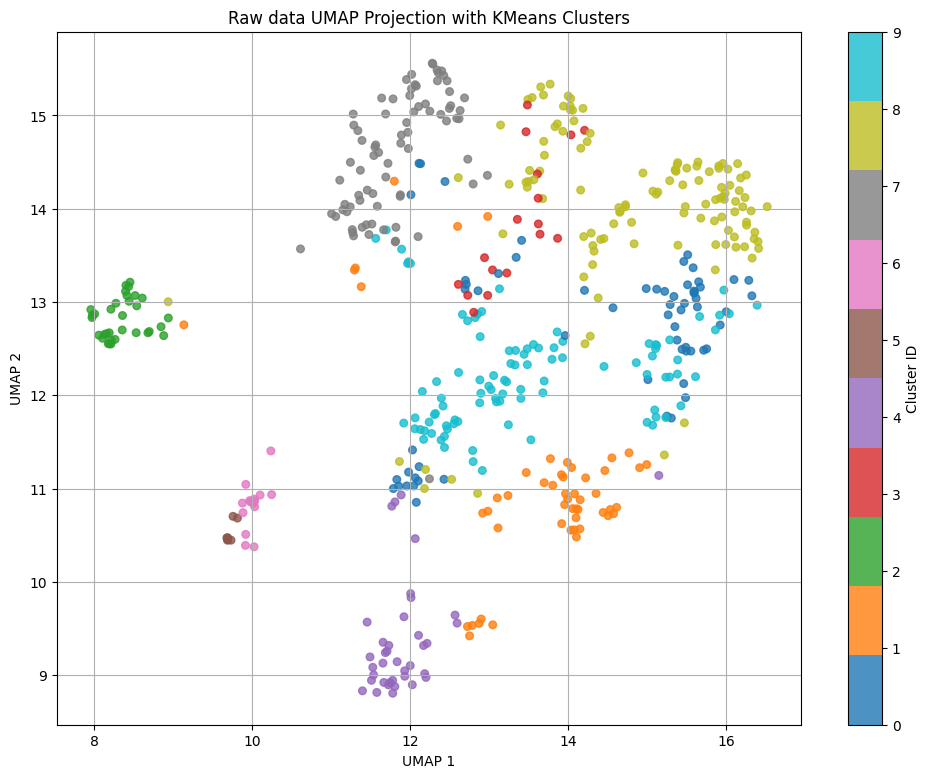

In [64]:
import torch
import gzip
import pickle
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. dev 데이터 로드
test_file_path = '/content/drive/MyDrive/phoenix14t.pami0.dev'
with gzip.open(test_file_path, 'rb') as f:
    data_dev = pickle.load(f)

# 2. sign 데이터만 추출
sign_list_dev = []
for entry in data_dev:
    sign = entry.get("sign", None)
    if isinstance(sign, torch.Tensor) and sign.numel() > 0:
        sign_list_dev.append(sign)

# sign 데이터를 [T, D] → (D,) 평균 벡터로 변환
features = [np.mean(s.numpy(), axis=0) for s in sign_list_dev]
features = np.array(features)
print("총 샘플 수:", len(features))
print("각 샘플 벡터의 shape:", features.shape)

# 3. UMAP 임베딩
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = umap_model.fit_transform(features)

# 4. KMeans 클러스터링 (예: 10개 클러스터)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(features)

# 5. 시각화
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    embedding[:, 0], embedding[:, 1],
    c=cluster_ids, cmap='tab10', s=30, alpha=0.8
)
plt.title("Raw data UMAP Projection with KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()


In [57]:
import pickle

file_path = '/content/drive/MyDrive/GCN-ResNet_200_output.pickle'

with open(file_path, 'rb') as f:
    data = pickle.load(f)  # gzip 사용 X

print(type(data))

# print((data))

<class 'list'>


In [2]:
import gzip
import numpy as np
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. 압축된 NumPy 파일 열기
file_path = '/content/drive/MyDrive/BiLSTMResNetModel_200_output.npy.gz'
with gzip.open(file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)

print("불러온 데이터 타입:", type(data))
#print(data)  # 데이터 내용 확인 (많은 데이터가 출력될 수 있음)

# 2. 유효한 시계열 데이터만 추출하고 시간 축 평균 계산
features = []
for arr in data:
    if isinstance(arr, np.ndarray) and arr.ndim == 2:
        # 각 시계열(2D 배열)의 시간 축(행)에 대한 평균을 계산
        features.append(np.mean(arr, axis=0))  # 결과 shape: (D,)
features = np.array(features)

print("총 샘플 수:", features.shape[0])
print("각 샘플 벡터의 shape:", features.shape)

# 3. UMAP 임베딩 (2차원으로 축소)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = umap_model.fit_transform(features)

# 4. 클러스터링 (예: 10개 클러스터)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# 5. 시각화: 클러스터에 따라 색 다르게 표시
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=cluster_labels, cmap='tab10', s=30, alpha=0.8)
plt.title("BiLSTM-ResNet U-MAP Projection with KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()


EOFError: Compressed file ended before the end-of-stream marker was reached

불러온 데이터 타입: <class 'numpy.ndarray'>
총 샘플 수: 519
각 샘플 벡터의 shape: (519, 1024)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


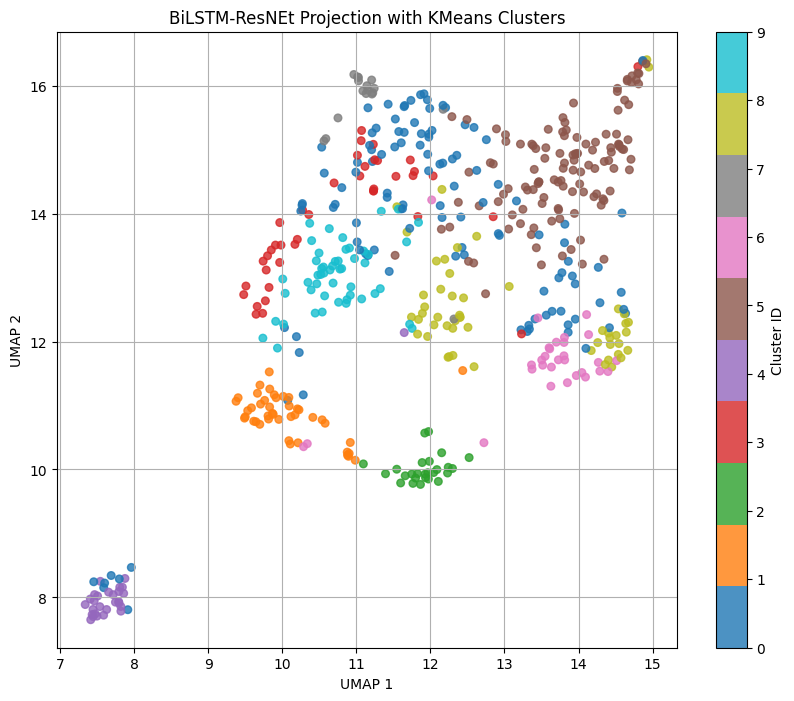

In [11]:
import gzip
import numpy as np
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. 압축된 NumPy 파일 열기
file_path = '/content/drive/MyDrive/BiLSTMResNetModel_200_output.npy.gz'
with gzip.open(file_path, 'rb') as f:
    data = np.load(f, allow_pickle=True)

print("불러온 데이터 타입:", type(data))
#print(data)  # 데이터 내용 확인 (많은 데이터가 출력될 수 있음)

# 2. 유효한 시계열 데이터만 추출하고 시간 축 평균 계산
features = []
for arr in data:
    if isinstance(arr, np.ndarray) and arr.ndim == 2:
        # 각 시계열(2D 배열)의 시간 축(행)에 대한 평균을 계산
        features.append(np.mean(arr, axis=0))  # 결과 shape: (D,)
features = np.array(features)

print("총 샘플 수:", features.shape[0])
print("각 샘플 벡터의 shape:", features.shape)

# 3. UMAP 임베딩 (2차원으로 축소)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = umap_model.fit_transform(features)

# 4. 클러스터링 (예: 10개 클러스터)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# 5. 시각화: 클러스터에 따라 색 다르게 표시
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=cluster_labels, cmap='tab10', s=30, alpha=0.8)
plt.title("BiLSTM-ResNEt Projection with KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()


총 샘플 수: 519
각 샘플 벡터의 shape: (519, 1024)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


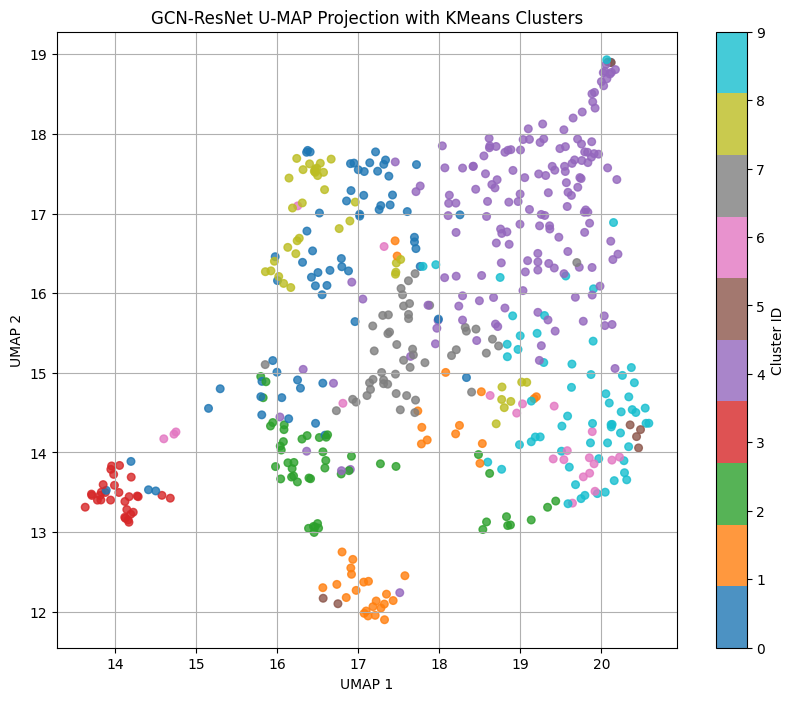

In [71]:
import pickle
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 1. 데이터 로드
file_path = '/content/drive/MyDrive/GCN-ResNet_200_output.pickle'

with open(file_path, 'rb') as f:
    data_dev = pickle.load(f)

# 2. 유효한 시계열 데이터만 추출하고 시간 축 평균
features = []
for arr in data_dev:
    if isinstance(arr, np.ndarray) and arr.ndim == 2:
        features.append(np.mean(arr, axis=0))  # shape: (D,)
features = np.array(features)

print("총 샘플 수:", features.shape[0])
print("각 샘플 벡터의 shape:", features.shape)

# 3. UMAP 임베딩
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = umap_model.fit_transform(features)

# 4. 클러스터링 (예: 10개 클러스터)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# 5. 시각화: 클러스터에 따라 색 다르게
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=cluster_labels, cmap='tab10', s=30, alpha=0.8)
plt.title("GCN-ResNet U-MAP Projection with KMeans Clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()


In [76]:
# 임베딩 결과(embedding)는 shape: (num_samples, 2)
# x축은 embedding[:, 0], y축은 embedding[:, 1]

# 조건에 맞는 포인트를 찾기 위한 마스크 생성
mask = (embedding[:, 0] >= 0) & (embedding[:, 0] <= 15) & (embedding[:, 1] >= 13) & (embedding[:, 1] <= 14)

# 조건을 만족하는 인덱스와 해당 포인트 추출
selected_indices = np.where(mask)[0]
selected_points = embedding[mask]

print("지정한 범위 내 데이터 포인트 수:", selected_points.shape[0])
print("해당 데이터 인덱스:", selected_indices)
print("해당 데이터 UMAP 좌표:")
print(selected_points)

test_file_path = '/content/drive/MyDrive/phoenix14t.pami0.dev'
with gzip.open(test_file_path, 'rb') as f:
    test_data = pickle.load(f)

# 각 샘플의 'gloss' 헤더를 추출합니다.
# test_data가 리스트이고, 각 항목이 dict라 가정합니다.
gloss_list = [entry['gloss'] for entry in test_data if isinstance(entry, dict) and 'gloss' in entry]

# 이전 코드에서 도출한 인덱스 selected_indices가 있다고 가정합니다.
# 예시: selected_indices = np.where(mask)[0]  (앞서 도출한 코드)
print("선택된 인덱스:", selected_indices)
print("선택된 인덱스에 해당하는 'gloss' 값:")

for idx in selected_indices:
    # 인덱스가 gloss_list 범위 내에 있는지 확인합니다.
    if idx < len(gloss_list):
        print(f"Index {idx}: {gloss_list[idx]}")
    else:
        print(f"Index {idx} is out of range. Total gloss entries: {len(gloss_list)}")

지정한 범위 내 데이터 포인트 수: 34
해당 데이터 인덱스: [  4  53  57  83 110 111 131 142 162 171 190 191 207 213 214 240 249 289
 329 352 365 370 412 417 424 438 439 447 449 465 480 485 487 510]
해당 데이터 UMAP 좌표:
[[14.282287  13.444646 ]
 [14.118625  13.384167 ]
 [13.827319  13.500419 ]
 [14.2213125 13.249225 ]
 [14.044665  13.49732  ]
 [14.193301  13.887467 ]
 [13.877077  13.497276 ]
 [13.810417  13.459681 ]
 [13.989447  13.587615 ]
 [13.778917  13.401204 ]
 [14.125229  13.172761 ]
 [13.82199   13.402944 ]
 [13.888078  13.524759 ]
 [14.190582  13.224097 ]
 [13.95429   13.830436 ]
 [13.628387  13.312573 ]
 [14.168052  13.123601 ]
 [14.052264  13.836725 ]
 [13.944818  13.78787  ]
 [13.942014  13.402101 ]
 [14.141834  13.282872 ]
 [14.678778  13.425855 ]
 [14.116604  13.185385 ]
 [14.196284  13.689965 ]
 [13.8499975 13.596126 ]
 [13.979632  13.724673 ]
 [14.57548   13.461565 ]
 [14.499346  13.51664  ]
 [13.705987  13.476992 ]
 [14.2708025 13.45316  ]
 [14.1707325 13.444871 ]
 [14.157862  13.152473 ]
 [13.71023

In [78]:
# 임베딩 결과(embedding)는 shape: (num_samples, 2)
# x축은 embedding[:, 0], y축은 embedding[:, 1]

# 조건에 맞는 포인트를 찾기 위한 마스크 생성
mask = (embedding[:, 0] >= 20) & (embedding[:, 0] <= 21) & (embedding[:, 1] >= 18) & (embedding[:, 1] <= 19)

# 조건을 만족하는 인덱스와 해당 포인트 추출
selected_indices = np.where(mask)[0]
selected_points = embedding[mask]

print("지정한 범위 내 데이터 포인트 수:", selected_points.shape[0])
print("해당 데이터 인덱스:", selected_indices)
print("해당 데이터 UMAP 좌표:")
print(selected_points)

test_file_path = '/content/drive/MyDrive/phoenix14t.pami0.dev'
with gzip.open(test_file_path, 'rb') as f:
    test_data = pickle.load(f)

# 각 샘플의 'gloss' 헤더를 추출합니다.
# test_data가 리스트이고, 각 항목이 dict라 가정합니다.
gloss_list = [entry['gloss'] for entry in test_data if isinstance(entry, dict) and 'gloss' in entry]

# 이전 코드에서 도출한 인덱스 selected_indices가 있다고 가정합니다.
# 예시: selected_indices = np.where(mask)[0]  (앞서 도출한 코드)
print("선택된 인덱스:", selected_indices)
print("선택된 인덱스에 해당하는 'gloss' 값:")

for idx in selected_indices:
    # 인덱스가 gloss_list 범위 내에 있는지 확인합니다.
    if idx < len(gloss_list):
        print(f"Index {idx}: {gloss_list[idx]}")
    else:
        print(f"Index {idx} is out of range. Total gloss entries: {len(gloss_list)}")

지정한 범위 내 데이터 포인트 수: 13
해당 데이터 인덱스: [  8  59  88  94 104 107 164 225 248 316 339 341 496]
해당 데이터 UMAP 좌표:
[[20.10564  18.75162 ]
 [20.117043 18.898918]
 [20.000181 18.656511]
 [20.02851  18.604368]
 [20.121517 18.895678]
 [20.08314  18.903906]
 [20.12411  18.772676]
 [20.057924 18.873463]
 [20.06614  18.931646]
 [20.040382 18.78825 ]
 [20.023972 18.769226]
 [20.068316 18.6922  ]
 [20.17359  18.80755 ]]
선택된 인덱스: [  8  59  88  94 104 107 164 225 248 316 339 341 496]
선택된 인덱스에 해당하는 'gloss' 값:
Index 8: SCHOEN ABEND WUENSCHEN
Index 59: LIEB ZUSCHAUER poss-EUCH GUT ABEND
Index 88: IHR WUENSCHEN ABEND MACHEN GUT
Index 94: SCHOEN ABEND AUSRICHTEN
Index 104: GUT ABEND LIEB ZUSCHAUER
Index 107: SCHOEN ABEND WUENSCHEN MACHEN GUT WUENSCHEN
Index 164: GUT ABEND LIEB DU ZUSCHAUER poss-EUCH
Index 225: SCHOEN ABEND MACHEN poss-EUCH GUT
Index 248: SCHOEN ABEND poss-EUCH MACHEN GUT poss-EUCH
Index 316: LIEB ZUSCHAUER GUT ABEND
Index 339: SCHOEN ABEND MACHEN GUT
Index 341: LIEB ZUSCHAUER poss-EUCH GUT ABEN

Phoenix dev 샘플 수: (519, 1024)
GCN-ResNet 샘플 수: (519, 1024)


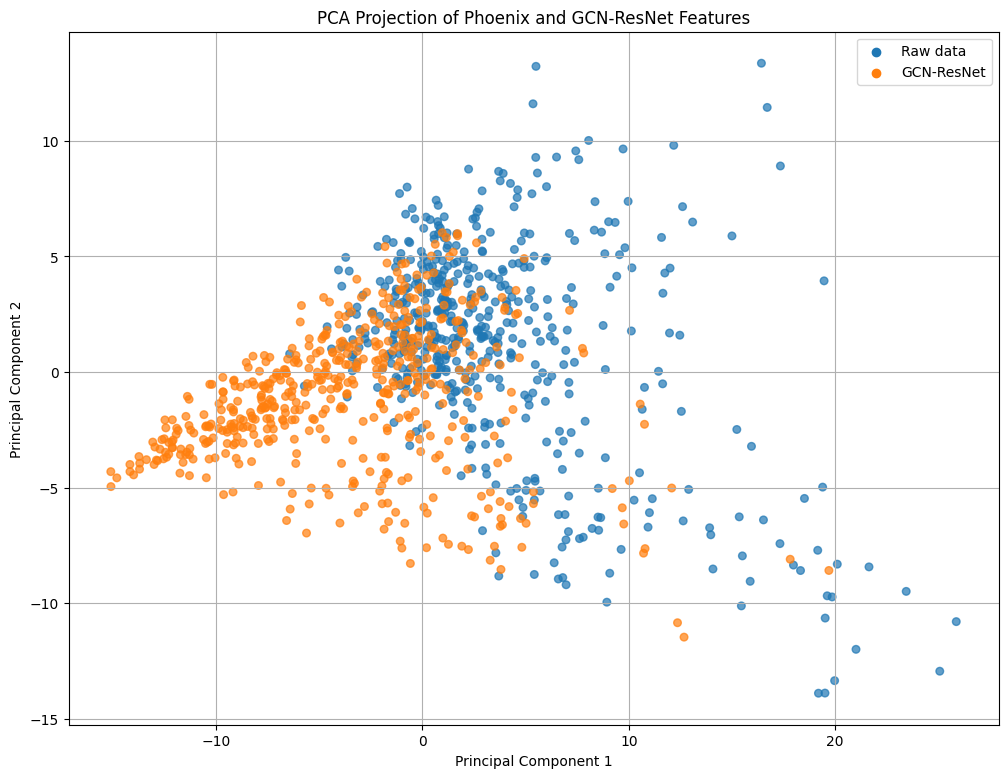

In [68]:
import torch
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. 첫 번째 데이터: phoenix14t.pami0.dev
phoenix_file_path = '/content/drive/MyDrive/phoenix14t.pami0.dev'
with gzip.open(phoenix_file_path, 'rb') as f:
    data_dev = pickle.load(f)

sign_features = []
for entry in data_dev:
    sign = entry.get("sign", None)
    if isinstance(sign, torch.Tensor) and sign.numel() > 0:
        sign_features.append(np.mean(sign.numpy(), axis=0))

sign_features = np.array(sign_features)
print("Phoenix dev 샘플 수:", sign_features.shape)

# 2. 두 번째 데이터: GCN-ResNet_200_output.pickle
gcn_resnet_file_path = '/content/drive/MyDrive/GCN-ResNet_200_output.pickle'
with open(gcn_resnet_file_path, 'rb') as f:
    gcn_data = pickle.load(f)

gcn_features = []
for arr in gcn_data:
    if isinstance(arr, np.ndarray) and arr.ndim == 2:
        gcn_features.append(np.mean(arr, axis=0))

gcn_features = np.array(gcn_features)
print("GCN-ResNet 샘플 수:", gcn_features.shape)

# 3. 두 데이터 병합
all_features = np.vstack([sign_features, gcn_features])
labels = (
    ['Phoenix'] * len(sign_features) +
    ['GCN-ResNet'] * len(gcn_features)
)

# 4. PCA 임베딩
pca = PCA(n_components=2)
embedding = pca.fit_transform(all_features)

# 5. 시각화
plt.figure(figsize=(12, 9))
colors = ['#1f77b4' if label == 'Phoenix' else '#ff7f0e' for label in labels]
plt.scatter(
    embedding[:, 0], embedding[:, 1],
    c=colors, alpha=0.7, s=30,
)

# 범례 표시
for label_name, color in [('Raw data', '#1f77b4'), ('GCN-ResNet', '#ff7f0e')]:
    plt.scatter([], [], c=color, label=label_name)

plt.legend()
plt.title("PCA Projection of Phoenix and GCN-ResNet Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils
import math
import gzip
import pickle

# --- 1. 데이터 로드 및 전처리 ---
file_path = '/content/drive/MyDrive/phoenix14t.pami0.test'
with gzip.open(file_path, 'rb') as f:
    data = pickle.load(f)

sign_list = []
for entry in data:
    sign = entry.get("sign", None)
    if isinstance(sign, torch.Tensor) and sign.numel() > 0:
        sign_list.append(sign)

# --- 2. Custom Dataset ---
class SignDataset(Dataset):
    def __init__(self, sign_list):
        # 여기서는 각 샘플의 shape이 [T, 1024]라고 가정합니다.
        self.samples = [s for s in sign_list if isinstance(s, torch.Tensor) and s.numel() > 0]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# --- 3. Collate Function for Padding ---
def pad_collate_fn(batch):
    lengths = [s.shape[0] for s in batch]
    padded = rnn_utils.pad_sequence(batch, batch_first=True)  # [B, T_max, 1024]
    mask = torch.zeros(padded.shape[:2], dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :l] = True
    return padded, mask, lengths

# --- 기존 GCN Model (참고용) ---
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.matmul(input, self.weight)
        output = torch.matmul(adj, support)
        if self.bias is not None:
            output = output + self.bias
        return output

class GCNFeature(nn.Module):
    def __init__(self, nfeat, nhid, gcn_out, dropout):
        super(GCNFeature, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, gcn_out)
        self.dropout = dropout

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return x

class GCNModel(nn.Module):
    def __init__(self, input_dim=1024, nhid=512, gcn_out=256, dropout=0.5):
        super(GCNModel, self).__init__()
        self.gcn = GCNFeature(input_dim, nhid, gcn_out, dropout)
        self.proj = nn.Linear(gcn_out, input_dim)

    def forward(self, x, mask):
        B, T, F = x.shape
        adj = torch.eye(T, device=x.device).unsqueeze(0).expand(B, T, T)
        x_out = torch.stack([self.gcn(x[i], adj[i]) for i in range(B)])
        recon = self.proj(x_out)
        return x_out, recon

# --- 새로 추가할 LSTM 모델 ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=256, num_layers=1, dropout=0.5):
        """
        input_dim: 입력 feature 차원 (여기서는 1024)
        hidden_dim: LSTM hidden state 차원 (예: 256)
        num_layers: LSTM 레이어 수
        dropout: LSTM 레이어 간 dropout 비율
        """
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        # LSTM의 출력을 input_dim 크기로 투영 (출력 shape: [B, T, input_dim])
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # x: [B, T, input_dim] (여기서는 input_dim=1024)
        lstm_out, _ = self.lstm(x)  # lstm_out: [B, T, hidden_dim]
        output = self.fc(lstm_out)  # output: [B, T, input_dim]
        return output

# --- 데이터 로더 생성 ---
dataset = SignDataset(sign_list)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=pad_collate_fn, num_workers=0)

# --- LSTM 모델 학습 예시 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LSTM 모델의 input_dim을 1024로 수정합니다.
lstm_model = LSTMModel(input_dim=1024, hidden_dim=256, num_layers=1, dropout=0.5).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 200  # 예시로 10 에폭 학습
lstm_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_data, batch_mask, batch_lengths in dataloader:
        batch_data = batch_data.to(device)  # batch_data: [B, T, 1024]

        optimizer.zero_grad()
        output = lstm_model(batch_data)  # output: [B, T, 1024]
        loss = criterion(output, batch_data)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, LSTM Loss: {epoch_loss:.6f}")

# 예시: 학습 후 첫 배치의 결과 출력
lstm_model.eval()
with torch.no_grad():
    batch_data, batch_mask, batch_lengths = next(iter(dataloader))
    batch_data = batch_data.to(device)
    output = lstm_model(batch_data)
    print("LSTM input shape:", batch_data.shape)
    print("LSTM output shape:", output.shape)
    print("First sample (first 5 frames, first 5 features):")
    print(output[0][:5, :5])


Epoch 1/10, LSTM Loss: 205.337672
Epoch 2/10, LSTM Loss: 134.670577
Epoch 3/10, LSTM Loss: 110.711418


KeyboardInterrupt: 